In [2]:
import numpy as np 
import pandas as pd 
from numpy.linalg import eig
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from collections import Counter
import nltk
nltk.download("wordnet")
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
!pip install demoji
import demoji

import time

/opt/conda/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [17]:
# import os
# os.chdir(r'/kaggle/working')


In [3]:
hashtag_trump = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv",engine ="python")
hashtag_biden = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_joebiden.csv",engine ="python")
biden_tweets = pd.read_csv("/kaggle/input/individual-tweets/tweets_of_joe_biden.csv",engine ="python")
trump_tweets = pd.read_json("/kaggle/input/individual-tweets/trump-tweets.json")

### Turning Trump's and Joe's tweets into correct dtypes

In [4]:
hashtag_trump['created_at'] = pd.to_datetime(hashtag_trump['created_at'], errors='coerce')
hashtag_trump['collected_at'] = pd.to_datetime(hashtag_trump['collected_at'], errors='coerce')
hashtag_trump['user_join_date'] = pd.to_datetime(hashtag_trump['user_join_date'], errors='coerce')
columns = ['tweet_id', 'likes', 'retweet_count', 'user_id', 'user_followers_count', 'lat', 'long']
hashtag_trump[columns] = hashtag_trump[columns].apply(pd.to_numeric, errors='coerce')
hashtag_trump.dropna(subset=['created_at', 'tweet_id', 'likes', 'retweet_count', 'user_id', 'user_followers_count', 'lat', 'long', 'collected_at'], inplace=True)


hashtag_biden['created_at'] = pd.to_datetime(hashtag_biden['created_at'], errors='coerce')
hashtag_biden['collected_at'] = pd.to_datetime(hashtag_biden['collected_at'], errors='coerce')
hashtag_biden['user_join_date'] = pd.to_datetime(hashtag_biden['user_join_date'], errors='coerce')
hashtag_biden[columns] = hashtag_biden[columns].apply(pd.to_numeric, errors='coerce')
hashtag_biden.dropna(subset=['created_at', 'tweet_id', 'likes', 'retweet_count', 'user_id', 'user_followers_count', 'lat', 'long', 'collected_at'], inplace=True)

The trump data now has a status column which says if the tweet if the tweet is "normal", "Resitrcited" or "deleted".We have also converted all the 'favorites' and the 'retweets' into integers. 

#### Removing tweets with both hashtags

In [5]:
#Find tweets which hashtag both
hashtag_both = hashtag_trump.merge(hashtag_biden, how='inner', on='tweet_id')
#hashtag_both.shape|

In [6]:
#Remove common tweets from each dataset
hashtag_justbiden = hashtag_biden[~hashtag_biden['tweet_id'].isin(hashtag_both.tweet_id)]
hashtag_justtrump = hashtag_trump[~hashtag_trump['tweet_id'].isin(hashtag_both.tweet_id)]


In [7]:
all_tweets = pd.concat([hashtag_justtrump,hashtag_justbiden])

In [8]:
US = ['United States of America']

#Biden location groupping
B_US_df = hashtag_biden.loc[hashtag_biden['country'].isin(US)]
B_US_df.insert(1, 'tweet_time', pd.to_datetime(B_US_df['created_at']).dt.time)
B_US_df.insert(1, 'tweet_day', pd.to_datetime(B_US_df['created_at']).dt.date)
B_US_df = B_US_df.astype({'likes': 'float'})
to_c_filter = ['user_id', 'user_name', 'user_location', 'user_screen_name', 'user_description', 'user_join_date', 'city', 'continent', 'state_code']
for cf in to_c_filter:
    B_US_df = B_US_df.drop(labels = cf, axis = 1)
B_groupped_by_states = B_US_df.groupby('state')

#Trump location groupping
T_US_df = hashtag_trump.loc[hashtag_trump['country'].isin(US)]
T_US_df.insert(1, 'tweet_time', pd.to_datetime(T_US_df['created_at']).dt.time)
T_US_df.insert(1, 'tweet_day', pd.to_datetime(T_US_df['created_at']).dt.date)
T_US_df = T_US_df.astype({'likes': 'float'})
to_c_filter = ['user_id', 'user_name', 'user_location', 'user_screen_name', 'user_description', 'user_join_date', 'city', 'continent', 'state_code']
for cf in to_c_filter:
    T_US_df = T_US_df.drop(labels = cf, axis = 1)
T_groupped_by_states = T_US_df.groupby('state')

In [12]:
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595026 entries, 2 to 777070
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   created_at            595026 non-null  datetime64[ns]
 1   tweet_id              595026 non-null  float64       
 2   tweet                 595026 non-null  object        
 3   likes                 595026 non-null  float64       
 4   retweet_count         595026 non-null  float64       
 5   source                594870 non-null  object        
 6   user_id               595026 non-null  float64       
 7   user_name             595023 non-null  object        
 8   user_screen_name      595026 non-null  object        
 9   user_description      560170 non-null  object        
 10  user_join_date        595026 non-null  datetime64[ns]
 11  user_followers_count  595026 non-null  float64       
 12  user_location         595026 non-null  object        
 13 

#### Counting Mean Number of Words

In [ ]:
wordcount = list()
for t in all_tweets["tweet"]:
    print(t)
    wordcount.append(len(t))
print('Total number of words: ', np.sum(wordcount))
print('Mean number of words per tweet: ', np.mean(wordcount))
print('Standard Deviation of words per tweet: ', np.std(wordcount))
print('Range of words: ', np.min(wordcount), np.max(wordcount))

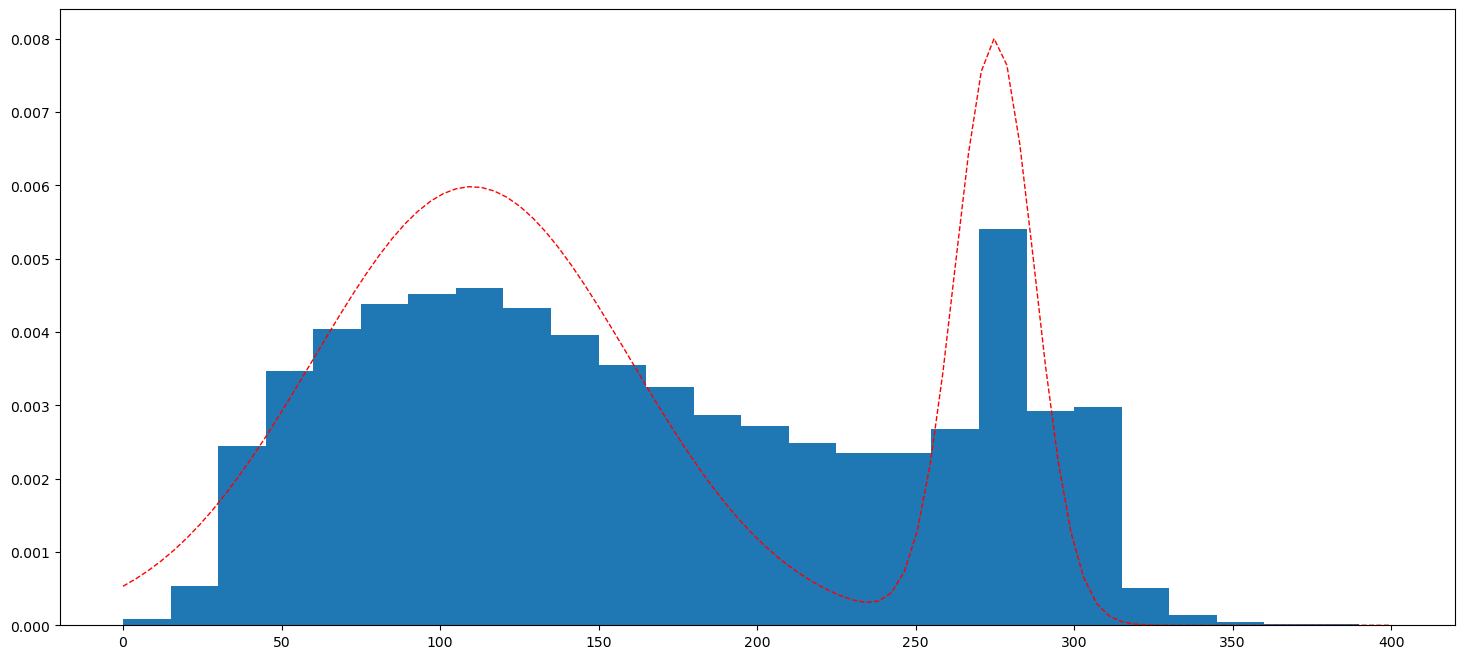

In [12]:
import scipy.stats as stats
r = np.linspace(0,400,100)
#y1 = stats.norm.pdf(r, np.mean(wordcount), np.std(wordcount))
y1 = stats.norm.pdf(r, 110, 50)
y2 = stats.norm.pdf(r, 275, 12.5)
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(wordcount, bins=range(0, 400, 15), density=True);
ax.plot(r, 0.75*y1+0.25*y2, 'r--', linewidth=1);
# ax.set_title('Headline word lengths');
# ax.set_xticks(range(1,14));
# ax.set_xlabel('Number of words');
# plt.show()

### Languages of tweets

In [ ]:
#Uncomment to run on whole dataset - this will take ages! once in output folder just uncomment read in line instead
from pathlib import Path
out= '../output' # folder to save intermediary data to
Path(out).mkdir(parents=True, exist_ok=True)

#This runs language analysis on whole dataset -  DO NOT RUN WILL TAKE 1MILLION HOURS
#Run separately on each dataset so can use 
#lang_B = B_US_df[['tweet_id','tweet', 'state_code']].copy()
#lang_B['language']  = B_US_df[['tweet_id','tweet', 'state_code']].tweet.apply(lambda i:get_lang(i))
#lang_B.to_csv(out + '/lang_Biden.csv', index=False)
#lang_T = T_US_df[['tweet_id','tweet', 'state_code']].copy()
#lang_T['language']  = T_US_df[['tweet_id','tweet', 'state_code']].tweet.apply(lambda i:get_lang(i))
#lang_T.to_csv(out + '/lang_Trump.csv', index=False)

#Read in language files
lang_B = pd.read_csv("/kaggle/input/lang-uselectiontweets/lang_Biden.csv",engine ="python")
lang_T = pd.read_csv("/kaggle/input/lang-uselectiontweets/lang_Trump.csv",engine ="python")

#Make graphs based on whole dataset
total_US_dfsample = pd.concat([lang_B.copy(),lang_T.copy()])
total_US_dfsample

We can see above that Puerto Rico has majority Spanish language in their tweets. Puerto Rico is a US territory but citizens do not have Presidential Election voting rights. It might be worth excluding US territories who cannot vote? Or perhaps filtering to english only will suffice.

In [18]:
#Exclude non-english tweets
B_US_english = lang_B.loc[lang_B['language'] == 'en']
B_US_english.shape

(102622, 4)

In [19]:
#Exclude non-english tweets
T_US_english = lang_T.loc[lang_T['language'] == 'en']
T_US_english.shape

(137061, 4)

In [20]:
B_US_english

,tweet_id,tweet,state_code,language
0,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,MT,en
1,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,CA,en
3,1.316530e+18,In an effort to find the truth about allegatio...,IL,en
4,1.316530e+18,Twitter is doing everything they can to help D...,CA,en
7,1.316530e+18,Come on @ABC PLEASE DO THE RIGHT THING. Move t...,NY,en
...,...,...,...,...
122854,1.325588e+18,"#Biden 🗽🇺🇸👍🏽 | Images 📷 @ Santa Maria, CA. | ...",CA,en
122855,1.325588e+18,Will #criticalRaceTheory become ubiquitous in ...,PA,en
122856,1.325588e+18,You moving near #Biden 🤔 https://t.co/1F6i1YIJ2P,PA,en
122857,1.325589e+18,@FLOTUS I’m excited to have a FLOTUS whose vag...,DC,en


In [17]:
T_US_english

,tweet_id,tweet,state_code,language
0,1.316529e+18,"#Trump: As a student I used to hear for years,...",OR,en
1,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,DC,en
2,1.316529e+18,@CLady62 Her 15 minutes were over long time ag...,CA,en
3,1.316529e+18,@DeeviousDenise @realDonaldTrump @nypost There...,OH,en
4,1.316529e+18,One of the single most effective remedies to e...,PA,en
...,...,...,...,...
148170,1.325588e+18,@realDonaldTrump @marklevinshow NO #Hoax! The ...,IL,en
148171,1.325588e+18,"@RBReich Bob,\nit's pretty straight forward.\n...",CA,en
148173,1.325589e+18,"@Jim_Jordan FCK NO , Democrats and the #msm la...",NY,en
148175,1.325589e+18,@DonaldJTrumpJr Being a #tRump you are intimat...,NJ,en


In [21]:
B_US_lan_time = pd.merge(B_US_english, B_US_df[['created_at', 'tweet', 'tweet_id']],  how='left', left_on=['tweet_id'], right_on = ['tweet_id']).sort_values("created_at")
T_US_lan_time = pd.merge(T_US_english, T_US_df[['created_at', 'tweet', 'tweet_id']],  how='left', left_on=['tweet_id'], right_on = ['tweet_id']).sort_values("created_at")

B_US_lan_time = B_US_lan_time.rename(columns={"tweet_x": "tweet"}).drop(columns=["tweet_y"])
T_US_lan_time = T_US_lan_time.rename(columns={"tweet_x": "tweet"}).drop(columns=["tweet_y"])

B_US_lan_time = B_US_lan_time[(B_US_lan_time['state_code'] != "GU") & (B_US_lan_time['state_code'] != "PR") & (B_US_lan_time['state_code'] != "MP")]
T_US_lan_time = T_US_lan_time[(T_US_lan_time['state_code'] != "GU") & (T_US_lan_time['state_code'] != "PR") & (T_US_lan_time['state_code'] != "MP")]

# TOPIC ANALYSIS
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

https://www.youtube.com/watch?v=Y79sCtzddyA

In [22]:
n = 100000
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

at_symbol = "@"
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
hyper_link = r'https?://\S+'
hyper_link2 = r'https?://\s+'

### Biden Dataset Cleaning

In [23]:
B_clean = B_US_lan_time

In [24]:
#removes emojis- as they have no relevance to topics
B_clean['clean_tweet'] = B_clean['tweet'].apply(lambda x: demoji.replace(x, ""))
#removes &amp;
B_clean['clean_tweet'] = B_clean['clean_tweet'].apply(lambda x: re.sub("&amp;","", x))
#removes @
B_clean['clean_tweet'] = B_clean['clean_tweet'].apply(lambda x: re.sub(at_symbol,"", x))
#removes http
B_clean['clean_tweet'] = B_clean['clean_tweet'].apply(lambda x: re.sub(hyper_link,"", x))
B_clean['clean_tweet'] = B_clean['clean_tweet'].apply(lambda x: re.sub(hyper_link2,"", x))
#remove new line symbol
B_clean['clean_tweet'] = B_clean['clean_tweet'].apply(lambda x: re.sub("\n","", x))
#remove 's
B_clean['clean_tweet'] = B_clean['clean_tweet'].apply(lambda x: re.sub("'s","", x))
# https://stackoverflow.com/questions/68448243/efficient-way-to-split-multi-word-hashtag-in-python
B_clean['clean_tweet'] = B_clean['clean_tweet'].apply(lambda x: re.sub(r'#[a-zA-Z]+', lambda m: ' '.join(re.findall('[A-Z][^A-Z]*|[a-z][^A-Z]*', m.group().lstrip('#'))), x))
# Remove punctuation
B_clean['clean_tweet'] = B_clean['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
#remove camel case
B_clean['clean_tweet'] = B_clean['clean_tweet'].apply(lambda x: re.sub(r'(?<=[a-z])(?=[A-Z])|(?<=[A-Za-z])(?=[0-9])', ' ', x))

In [ ]:
#print(B_clean['clean_tweet'][:100])

In [25]:
def clean_tweets(tweets):
    cleaned_tweets = list()
    for index,tweet in enumerate(tweets):
        tweet = re.sub(r"|", "",tweet)
        tweet = ' '.join([word for word in tweet.split() if word.lower() not in stopwords_dict])
        cleaned_tweets.insert(index,tweet)
    return cleaned_tweets

In [26]:
B_clean['clean_tweet'] = clean_tweets(list(B_clean['clean_tweet']))

In [27]:
lemmatizer = WordNetLemmatizer()

In [28]:
lemmatized_tweets_b = list()
for t in B_clean['clean_tweet']:
    word_list = nltk.word_tokenize(t)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w).upper() for w in word_list if len(str(w)) != 1 and re.search('[a-zA-Z]', str(w)) != None])
    lemmatized_tweets_b.append(lemmatized_output)
B_clean['lemmatized_tweets'] = lemmatized_tweets_b

Merges words that often come together into one using _

In [29]:
tokenized_lemmatised_b = list()
for i in B_clean["lemmatized_tweets"]:
    tokenized_lemmatised_b.append(i.split())

In [30]:
bigram_b = gensim.models.Phrases(tokenized_lemmatised_b, min_count=1500, threshold=1) # higher threshold fewer phrases.
trigram_b = gensim.models.Phrases(bigram_b[tokenized_lemmatised_b], min_count=2000, threshold=1)  
# bigram_b = gensim.models.Phrases(tokenized_lemmatised_b, min_count=15, threshold=1) # higher threshold fewer phrases.
# trigram_b = gensim.models.Phrases(bigram_b[tokenized_lemmatised_b], min_count=20, threshold=1)  
bigram_mod_b = gensim.models.phrases.Phraser(bigram_b)
trigram_mod_b = gensim.models.phrases.Phraser(trigram_b)

In [31]:
gram_model_b = list()
gram_model_joined_b = list()
for i in tokenized_lemmatised_b:
    gram_model_b.append(trigram_mod_b[bigram_mod_b[i]])
    gram_model_joined_b.append(" ".join(trigram_mod_b[bigram_mod_b[i]]))
B_clean["gram_model_tweets"] = gram_model_b
B_clean["gram_model_joined_tweets"] = gram_model_joined_b

### GSDMM

In [32]:
# dictionary
dictionary = corpora.Dictionary(B_clean["gram_model_tweets"])
# bag of word corpus

corpus = [dictionary.doc2bow(text) for text in B_clean["gram_model_tweets"]]


In [33]:
!pip install git+https://github.com/rwalk/gsdmm.git

  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-fxrbpq_x
  Running command git clone --filter=blob:none --quiet https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-fxrbpq_x
  Resolved https://github.com/rwalk/gsdmm.git to commit 4ad1b6b6976743681ee4976b4573463d359214ee
  Preparing metadata (setup.py) ... done
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4601 sha256=10c51c12c3c8a2579de6f3f20ce4fa90bfbb5f7a0b4e9d850e49c62d991eeccb
  Stored in directory: /tmp/pip-ephem-wheel-cache-ik2uf888/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm


In [34]:
from gsdmm import MovieGroupProcess

In [51]:
texts = B_clean["gram_model_tweets"]
texts = texts.to_numpy()
print(len(texts))

102796


In [36]:
# dictionary = corpora.Dictionary(B_clean["gram_model_tweets"][:1000])
# bag of word corpus

# corpus = [dictionary.doc2bow(text) for text in B_clean["gram_model_tweets"][:1000].values]

In [52]:
dictionary = corpora.Dictionary(texts)
# bag of word corpus

corpus = [dictionary.doc2bow(text) for text in texts]

In [53]:
start_time = time.time()

In [54]:
mgp = MovieGroupProcess(K=30, alpha=0.1, beta=0.3, n_iters=50)

# vocab = set(x for tweet in texts[:1000] for x in tweet)
# n_terms = 1000
# vocab = set(x for tweet in texts for x in tweet)
vocab_l = len(dictionary)
model = mgp.fit(texts, vocab_l)
# model = mgp.fit(texts[:1000], len(vocab))

In stage 0: transferred 96763 clusters with 30 clusters populated
In stage 1: transferred 58875 clusters with 30 clusters populated
In stage 2: transferred 24725 clusters with 30 clusters populated
In stage 3: transferred 17239 clusters with 30 clusters populated
In stage 4: transferred 15068 clusters with 30 clusters populated
In stage 5: transferred 14135 clusters with 30 clusters populated
In stage 6: transferred 13955 clusters with 30 clusters populated
In stage 7: transferred 13586 clusters with 30 clusters populated
In stage 8: transferred 13155 clusters with 30 clusters populated
In stage 9: transferred 13121 clusters with 30 clusters populated
In stage 10: transferred 13050 clusters with 30 clusters populated
In stage 11: transferred 12983 clusters with 30 clusters populated
In stage 12: transferred 12882 clusters with 30 clusters populated
In stage 13: transferred 12858 clusters with 30 clusters populated
In stage 14: transferred 12880 clusters with 30 clusters populated
In st

In [55]:
stop_time = time.time()
run_time = stop_time - start_time
print(run_time)

5982.6077353954315


In [ ]:
model = mgp.from_data(K=15, alpha=0.1, beta=0.3, D=len(texts), vocab_size=len(vocab), cluster_doc_count=model.cluster_doc_count, cluster_word_count=model.cluster_word_count, cluster_word_distribution=model.cluster_word_distribution)

In [56]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts)) 

In [57]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [   50    96    46  1020   104    25   193    60 44380   198    35    42
     4    82    97 24288 13991     9 16379   102    40   191   127    58
   692   102    22    86    28   249]

Most important clusters (by number of docs inside): [ 8 15 18 16  3 24 29  9  6 21]

Cluster 8 : [('BIDEN', 29209), ('JOE_BIDEN', 22532), ('TRUMP', 13254), ('VOTE', 8055), ('REAL_DONALD_TRUMP', 4602), ('PEOPLE', 4188), ('PRESIDENT', 4106), ('ELECTION', 4046), ('LIKE', 3844), ('DEBATE', 3618)]

Cluster 15 : [('BIDEN', 14062), ('JOE_BIDEN', 14028), ('BIDEN_HARRIS', 8467), ('TRUMP', 7565), ('ELECTION', 7337), ('VOTE', 5225), ('PRESIDENT', 4642), ('AMERICA', 4051), ('JOE_BIDEN_KAMALA_HARRIS', 4014), ('PRESIDENT_ELECT', 3050)]

Cluster 18 : [('BIDEN', 13266), ('VOTE', 7071), ('JOE_BIDEN', 6028), ('ELECTION', 5910), ('TRUMP', 3244), ('WIN', 2491), ('BIDEN_HARRIS', 2018), ('BALLOT', 1595), ('STATE', 1572), ('PENNSYLVANIA', 1546)]

Cluster 16 : [('BIDEN', 10680), ('JOE_BIDEN', 914

#### 50ITRS - 30 Clusters
Number of documents per topic : [   50    96    46  1020   104    25   193    60 44380   198    35    42
     4    82    97 24288 13991     9 16379   102    40   191   127    58
   692   102    22    86    28   249]

Most important clusters (by number of docs inside): [ 8 15 18 16  3 24 29  9  6 21]

Cluster 8 : [('BIDEN', 29209), ('JOE_BIDEN', 22532), ('TRUMP', 13254), ('VOTE', 8055), ('REAL_DONALD_TRUMP', 4602), ('PEOPLE', 4188), ('PRESIDENT', 4106), ('ELECTION', 4046), ('LIKE', 3844), ('DEBATE', 3618)]

Cluster 15 : [('BIDEN', 14062), ('JOE_BIDEN', 14028), ('BIDEN_HARRIS', 8467), ('TRUMP', 7565), ('ELECTION', 7337), ('VOTE', 5225), ('PRESIDENT', 4642), ('AMERICA', 4051), ('JOE_BIDEN_KAMALA_HARRIS', 4014), ('PRESIDENT_ELECT', 3050)]

Cluster 18 : [('BIDEN', 13266), ('VOTE', 7071), ('JOE_BIDEN', 6028), ('ELECTION', 5910), ('TRUMP', 3244), ('WIN', 2491), ('BIDEN_HARRIS', 2018), ('BALLOT', 1595), ('STATE', 1572), ('PENNSYLVANIA', 1546)]

Cluster 16 : [('BIDEN', 10680), ('JOE_BIDEN', 9140), ('HUNTER_BIDEN', 3745), ('TRUMP', 2366), ('CHINA', 2060), ('FAMILY', 1768), ('CRIME', 1678), ('HUNTER', 1642), ('JOE', 1477), ('ELECTION', 1429)]

Cluster 3 : [('VOTE', 1110), ('BIDEN', 1104), ('WI', 966), ('PERSON', 892), ('PA', 870), ('MI', 847), ('ABLE', 679), ('RT', 621), ('TRUMP', 598), ('VIDEO', 499)]

Cluster 24 : [('WTP', 1825), ('BLUE', 1209), ('DEM', 1076), ('WTPSENATE', 842), ('JOE_BIDEN', 688), ('CAST', 644), ('BIDEN', 626), ('BIDEN_HARRIS', 579), ('RESIST', 572), ('JOE_BIDEN_KAMALA_HARRIS', 566)]

Cluster 29 : [('BIDEN', 137), ('JOE_BIDEN', 86), ('TRUMP', 63), ('VOTE', 34), ('HARRIS', 34), ('BLUE', 31), ('REAL', 28), ('FOLLOW', 28), ('MC', 27), ('BIDEN_HARRIS', 26)]

Cluster 9 : [('WATCH', 318), ('JOE_BIDEN', 195), ('SECURITY', 175), ('WOULDNT', 169), ('NEED', 168), ('DEMOCRAT', 168), ('GET', 168), ('PRESIDENT', 168), ('POINT', 168), ('EVEN', 168)]

Cluster 6 : [('BIDEN', 341), ('VOTE', 317), ('PRESIDENT', 167), ('HUNTER_BIDEN', 155), ('EMAILS', 150), ('MEAN', 150), ('LIKELIHOOD', 150), ('SAVE_AMERICA', 149), ('IMPEACHED', 149), ('SOMETHING', 149)]

Cluster 21 : [('LIFE', 461), ('MIGHT', 282), ('JOE_BIDEN', 177), ('BIDEN_HARRIS', 168), ('MATTER', 168), ('DOWNBALLOT', 166), ('DEPENDS', 166), ('POLL', 165), ('SAY', 165), ('DEMOCRATIC', 165)]

Run time - 5982.6077353954315 secs
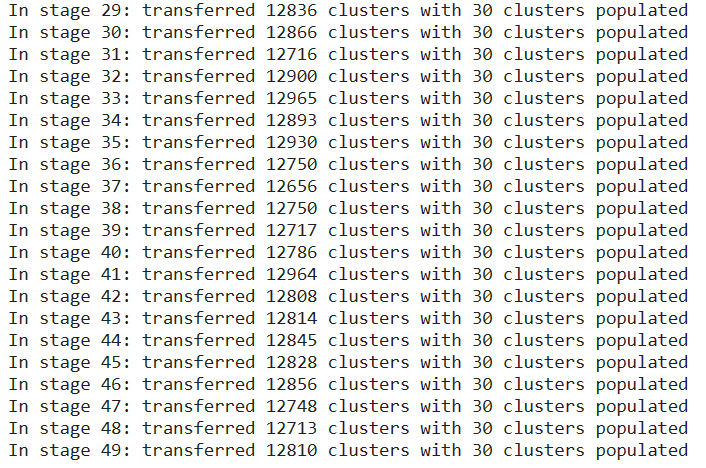

#### 100K RUN - 50 ITRS -TPOICS = 15

Number of documents per topic : [25254   796  9688   753 10967   320  1251 11101  5865  7127 11157  3355
 12626  2130   406]

Most important clusters (by number of docs inside): [ 0 12 10  7  4  2  9  8 11 13]

Cluster 0 : [('BIDEN', 16484), ('JOE_BIDEN', 12290), ('TRUMP', 7318), ('VOTE', 5983), ('PEOPLE', 3065), ('PRESIDENT', 2861), ('ELECTION', 2840), ('REAL_DONALD_TRUMP', 2802), ('AMERICA', 2396), ('LIKE', 2380)]

Cluster 12 : [('JOE_BIDEN', 8394), ('BIDEN', 5217), ('ELECTION', 4037), ('PRESIDENT', 3878), ('JOE_BIDEN_KAMALA_HARRIS', 2535), ('BIDEN_HARRIS', 2532), ('PRESIDENT_ELECT', 2415), ('KAMALA_HARRIS', 2234), ('AMERICA', 2191), ('JOE', 1503)]

Cluster 10 : [('BIDEN', 7291), ('JOE_BIDEN', 6520), ('TRUMP', 3638), ('DEBATE', 3019), ('JOE', 1305), ('REAL_DONALD_TRUMP', 1195), ('DEBATES', 1189), ('TOWN_HALL', 1075), ('TONIGHT', 1052), ('PRESIDENTIAL', 1023)]

Cluster 7 : [('BIDEN', 8807), ('JOE_BIDEN', 7478), ('HUNTER_BIDEN', 3754), ('CHINA', 1847), ('FAMILY', 1682), ('TRUMP', 1620), ('HUNTER', 1556), ('CRIME', 1554), ('CORRUPTION', 1236), ('JOE', 1198)]

Cluster 4 : [('BIDEN', 9458), ('ELECTION', 4881), ('VOTE', 4702), ('JOE_BIDEN', 3779), ('TRUMP', 2300), ('WIN', 2111), ('STATE', 1401), ('COUNT', 1303), ('PENNSYLVANIA', 1087), ('GEORGIA', 1052)]

Cluster 2 : [('BIDEN', 6860), ('TRUMP', 6015), ('VOTE', 5526), ('BIDEN_HARRIS', 5367), ('JOE_BIDEN', 4457), ('ELECTION', 2843), ('SAVE_AMERICA', 2660), ('VOTE_BLUE', 2123), ('BIDEN_BIDEN_HARRIS', 1664), ('AMERICA', 1452)]

Cluster 9 : [('BIDEN', 4065), ('JOE_BIDEN', 3941), ('ELECTION', 1130), ('TRUMP', 933), ('BIDEN_HARRIS', 929), ('VOTE', 917), ('OBAMA', 765), ('CAMPAIGN', 687), ('JOE', 521), ('PRESIDENT', 456)]

Cluster 8 : [('BIDEN', 4393), ('JOE_BIDEN', 2625), ('TRUMP', 1261), ('TAX', 1154), ('PLAN', 786), ('VOTE', 755), ('NEW', 617), ('ELECTION', 607), ('REAL_DONALD_TRUMP', 593), ('WOULD', 547)]

Cluster 11 : [('BIDEN', 2093), ('JOE_BIDEN', 1648), ('BLACK', 1112), ('TRUMP', 909), ('VOTE', 780), ('ELECTION', 457), ('MATTER', 391), ('LIVES', 306), ('AMERICA', 293), ('JOEBIDEN', 283)]

Cluster 13 : [('BIDEN', 1328), ('JOE_BIDEN', 943), ('COURT', 388), ('ELECTION', 379), ('VOTE', 378), ('SENATE', 374), ('AMY', 215), ('TRUMP', 212), ('MC', 205), ('SUPREME', 196)]

run time = 3374.851879835129

GSDMM Coherence Scores

In [45]:
def get_topics_lists(model, top_clusters, n_words):
    topics = []
    
    for cluster in top_clusters:
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]
        topic = []
        for k,v in sorted_dict:
            topic.append(k)
        
        topics.append(topic)
        return topics

In [ ]:
 topics = get_topics_lists(mgp, top_index,15)
cm_gsdmm = CoherenceModel(topics=topics, dictionary=dictionary, 
                          corpus=corpus,
                          texts,
#                           texts=texts[:1000],
                          coherence='c_v')

coherencemodel_umass = CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary,texts, coherence='u_mass') 
#                                     texts=texts[:1000]
# get coherence value
# perplexity_score = np.exp2(-model.log_perplexity(corpus))
coherence_gsdmm = cm_gsdmm.get_coherence()
ch_um = coherencemodel_umass.get_coherence()
# coherence_values_cv.append(coherence_gsdmm)

print("cv:", coherence_gsdmm)
print("umass:", ch_um)
# print(perplexity_score)

In [ ]:
sc_run_cv=coherence_gsdmm
sc_run_um = ch_um
print(sc_run_cv,sc_run_um)

In [ ]:
first_run_cv=coherence_gsdmm
first_run_um = ch_um
print(first_run_cv,first_run_um)


In [ ]:
# perplexity_score = np.exp2(-model.log_perplexity(corpus))
# print(perplexity_score)

In [ ]:
def prepare_vis_data(model, texts, vocab, K):
    def prepare_data():
        nonlocal mdl, texts, K
        doc_topic_dists = [model.score(text) for text in texts]
        doc_lengths = [len(text) for text in texts]
        doc_topic_dists2 = [[v if not math.isnan(v) else 1/K for v in d]
                            for d in doc_topic_dists]
        doc_topic_dists2 = [d if sum(d) > 0 else [1/K]*K for d in
                            doc_topic_dists]
        matrix = []
        for cluster in mdl.cluster_word_distribution:
            total = sum(cluster.values())
            row = [cluster.get(k, 0) / total for k in vocab]
            matrix.append(row)
        return matrix, doc_topic_dists2, doc_lengths

    out = pyLDAvis.prepare(*prepare_data(), vocab.keys(), vocab.values(),
                           sort_topics=False, mds='mmds')
    return out

In [ ]:
vis_data = prepare_vis_data(mdl, texts[:1000], vocab, K=10)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, gsdmm)

In [1]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values_um = []
    coherence_values_cv = []    
    model_list = []
    
    for num_topics in range(start, limit, step):
        mgp = MovieGroupProcess(K=num_topics, alpha=0.1, beta=0.1, n_iters=30)
        model = mgp.fit(texts, len(dictionary))
        model_list.append(model)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        topics = get_topics_lists(mgp, top_index,15)
        
        coherencemodel_umass = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherencemodel_cv = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_um.append(coherencemodel_umass.get_coherence())
        coherence_values_cv.append(coherencemodel_cv.get_coherence())
    return model_list, coherence_values_um, coherence_values_cv

In [2]:
def subset_runs(df, runs, sample_number):
    run_data = []
    for i in range(runs):
        print("run: ", i)
        subset = df[5000: 5000 + sample_number]
        dictionary = corpora.Dictionary(subset["gram_model_tweets"])
        corpus = [dictionary.doc2bow(text) for text in subset["gram_model_tweets"].values]
        model_list, coherence_values_um, coherence_values_cv = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=subset["gram_model_tweets"], start=5, limit=21, step=2)
        run_data.append([model_list, coherence_values_um, coherence_values_cv])
    return run_data

In [46]:
start_time = time.time()

In [47]:
subset_results = subset_runs(B_clean,5,1000)

run:  0
In stage 0: transferred 645 clusters with 5 clusters populated
In stage 1: transferred 316 clusters with 5 clusters populated
In stage 2: transferred 196 clusters with 5 clusters populated
In stage 3: transferred 161 clusters with 5 clusters populated
In stage 4: transferred 137 clusters with 5 clusters populated
In stage 5: transferred 122 clusters with 5 clusters populated
In stage 6: transferred 152 clusters with 5 clusters populated
In stage 7: transferred 144 clusters with 5 clusters populated
In stage 8: transferred 121 clusters with 5 clusters populated
In stage 9: transferred 116 clusters with 5 clusters populated
In stage 10: transferred 123 clusters with 5 clusters populated
In stage 11: transferred 132 clusters with 5 clusters populated
In stage 12: transferred 121 clusters with 5 clusters populated
In stage 13: transferred 118 clusters with 5 clusters populated
In stage 14: transferred 113 clusters with 5 clusters populated
In stage 15: transferred 112 clusters with

In [3]:
stop_time = time.time()
run_time = stop_time - start_time
print(run_time)
# time taken for run: 717 secs

NameError: name 'time' is not defined

In [1]:
subset_results_2 = pd.DataFrame(subset_results)
subset_results_2


NameError: name 'pd' is not defined

In [50]:
# subset_results_2.to_csv(r'/kaggle/working/b_results.csv', index=False)

In [40]:
subset_results = pd.read_csv("/kaggle/input/gsdmm-results-biden/b_results.csv",engine ="python")

In [41]:
subset_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5 non-null      object
 1   1       5 non-null      object
 2   2       5 non-null      object
dtypes: object(3)
memory usage: 248.0+ bytes


In [42]:
subset_results

,0,1,2
0,"[[0, 4, 0, 0, 0, 1, 2, 4, 0, 3, 0, 0, 0, 2, 4,...","[-3.4291963762360926, -3.9204691573514188, -3....","[0.23434825494145117, 0.24574823174247853, 0.2..."
1,"[[2, 3, 3, 2, 3, 0, 2, 4, 2, 0, 4, 1, 4, 0, 2,...","[-2.9707442581439025, -4.284307482879324, -3.5...","[0.2540376399899646, 0.2625422897378293, 0.266..."
2,"[[1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 4, 1, 1, 3,...","[-3.2590653090401, -3.006561459733572, -4.1182...","[0.25248843855544306, 0.26443989179170135, 0.2..."
3,"[[4, 4, 1, 0, 0, 3, 3, 0, 0, 3, 4, 1, 4, 0, 1,...","[-3.5445566263572363, -3.353847563925495, -3.1...","[0.2357835845131084, 0.24033477317090599, 0.23..."
4,"[[0, 2, 0, 1, 4, 2, 2, 3, 2, 3, 0, 4, 0, 2, 0,...","[-3.641567700805693, -3.1480542404382748, -4.2...","[0.2700030090569187, 0.2599398751517297, 0.329..."


In [43]:
u_mass = pd.DataFrame(subset_results[['0','1']])
c_v = pd.DataFrame(subset_results[['0','2']])
#     c_v = c_v.append(pd.Series(subset_results[[2][i]], index=c_v.columns[:len(subset_results[2][i])]), ignore_index=True)
u_mass
# c_v

,0,1
0,"[[0, 4, 0, 0, 0, 1, 2, 4, 0, 3, 0, 0, 0, 2, 4,...","[-3.4291963762360926, -3.9204691573514188, -3...."
1,"[[2, 3, 3, 2, 3, 0, 2, 4, 2, 0, 4, 1, 4, 0, 2,...","[-2.9707442581439025, -4.284307482879324, -3.5..."
2,"[[1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 4, 1, 1, 3,...","[-3.2590653090401, -3.006561459733572, -4.1182..."
3,"[[4, 4, 1, 0, 0, 3, 3, 0, 0, 3, 4, 1, 4, 0, 1,...","[-3.5445566263572363, -3.353847563925495, -3.1..."
4,"[[0, 2, 0, 1, 4, 2, 2, 3, 2, 3, 0, 4, 0, 2, 0,...","[-3.641567700805693, -3.1480542404382748, -4.2..."


In [44]:
# for i in range(0, 4, 1):
#     l = ast.literal_eval(subset_results.iloc[:,1].iloc[i])
#     u_mass = u_mass.append(pd.Series(l, index=u_mass.columns[:len(l)]), ignore_index=True)
# print(ast.literal_eval(subset_results.iloc[:,1].iloc[1]))
# len(ast.literal_eval(subset_results.iloc[:,1].iloc[1]))
import ast

In [49]:
# l = []
# l.append(u_mass['1'].apply(lambda y : ast.literal_eval(y)[0]).to_numpy().mean())

c_v['2']

0    [0.23434825494145117, 0.24574823174247853, 0.2...
1    [0.2540376399899646, 0.2625422897378293, 0.266...
2    [0.25248843855544306, 0.26443989179170135, 0.2...
3    [0.2357835845131084, 0.24033477317090599, 0.23...
4    [0.2700030090569187, 0.2599398751517297, 0.329...
Name: 2, dtype: object

In [50]:
# u_mass['1'].to_numpy()
u_mass['1']
mean_umass = []
mean_cv = []
for i in range(8):
    mean_umass.append(u_mass['1'].apply(lambda y: ast.literal_eval(y)[i]).to_numpy().mean())
    mean_cv.append(c_v['2'].apply(lambda y: ast.literal_eval(y)[i]).to_numpy().mean())

print(mean_umass,
mean_cv)

[-3.369026054116605, -3.542647980865617, -3.6359860826715233, -3.477707782081359, -3.902410730596489, -3.471005812273995, -3.7107450860940725, -3.4162837085016604] [0.2493321854113772, 0.25460101231892895, 0.26766255013876034, 0.3209981413701352, 0.29534505673953404, 0.2783915380809162, 0.2571234186145368, 0.34137511290601075]


In [51]:
print(mean_umass)

[-3.369026054116605, -3.542647980865617, -3.6359860826715233, -3.477707782081359, -3.902410730596489, -3.471005812273995, -3.7107450860940725, -3.4162837085016604]


In [60]:
# u_mass.iloc[[0]]
s = subset_results.iloc[:,1].iloc[0]
# l = ast.literal_eval(s)
print(s)
print(l)



<class 'str'>
<class 'list'>


In [52]:
umass_biden = pd.DataFrame(u_mass)
cv_biden = pd.DataFrame(c_v)
# perp_biden = pd.DataFrame(perp)
umass_biden.to_csv(r'/kaggle/working/umass_biden.csv', index=False)
cv_biden.to_csv(r'/kaggle/working/cv_biden.csv', index=False)
# perp_biden.to_csv(r'/kaggle/working/perp_biden.csv', index=False)

In [ ]:
u_mass_b = list(u_mass.mean())
c_v_b = list(c_v.mean())
# perp_b = list(perp.mean())

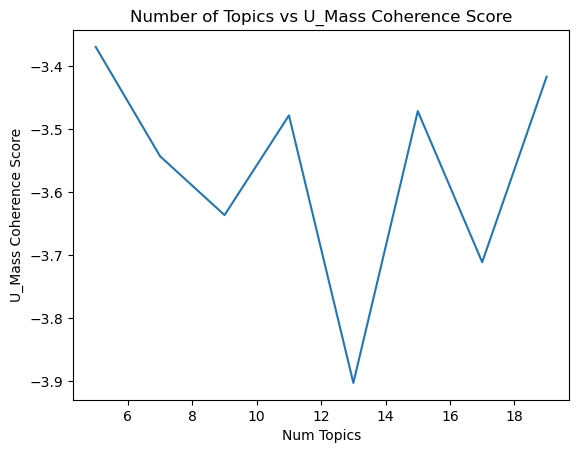

In [43]:
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.title("Number of Topics vs U_Mass Coherence Score")
plt.plot(x, mean_umass)
plt.xlabel("Num Topics")
plt.ylabel("U_Mass Coherence Score")
plt.savefig("u_mass_number_of_topic.png")
plt.show()

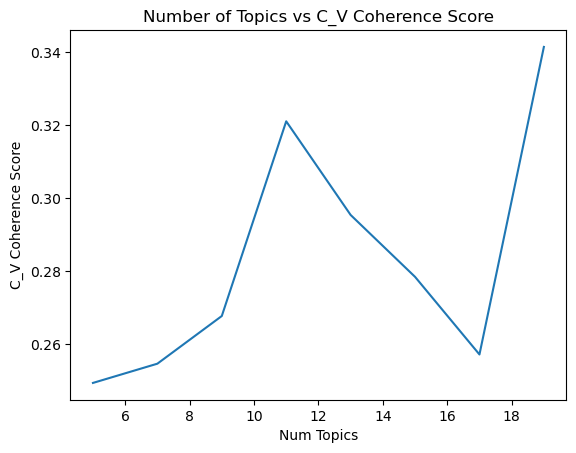

In [44]:
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.title("Number of Topics vs C_V Coherence Score")
plt.plot(x, mean_cv)
plt.xlabel("Num Topics")
plt.ylabel("C_V Coherence Score")
plt.savefig("c_v_number_of_topic.png")
plt.show()

#### Choosing the Number of Topic using Hyperparameter tuning only for LDA

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#google_vignette

In [64]:
def subset_runs2(df, runs, sample_number):
    run_data = []
    for i in range(runs):
        print("run: ", i)
        subset = df[5000:5000+sample_number]
        dictionary = corpora.Dictionary(subset["gram_model_tweets"])
        corpus = [dictionary.doc2bow(text) for text in subset["gram_model_tweets"].values]
        model_list, coherence_values_um, coherence_values_cv = compute_coherence_values2(dictionary=dictionary, corpus=corpus, texts=subset["gram_model_tweets"], start=5, limit=21, step=2)
        run_data.append([model_list, coherence_values_um, coherence_values_cv])
    return run_data

In [ ]:
#df_topics = pd.DataFrame(results_topics)
#df_topics.to_csv(r'/kaggle/working/topics_results_biden_5.csv', index=False)

In [65]:
def compute_coherence_values2(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values_um = []
    coherence_values_cv = []
#     perplexity = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           update_every=1,
                                           passes=3,
                                           iterations=10,
                                           chunksize=2000, 
                                           alpha='auto',
                                           eval_every=None,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel_umass = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherencemodel_cv = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         perplexity_score = np.exp2(-model.log_perplexity(corpus))
        coherence_values_um.append(coherencemodel_umass.get_coherence())
        coherence_values_cv.append(coherencemodel_cv.get_coherence())
#         perplexity.append(perplexity_score)
    return model_list, coherence_values_um, coherence_values_cv

In [66]:
lda_results = subset_runs2(B_clean,5,1000)

run:  0
run:  1
run:  2
run:  3
run:  4


In [67]:
results_topics_b = lda_results
results_topics_b

[[[<gensim.models.ldamodel.LdaModel at 0x7e2261c615d0>,
  [-5.088921967822683,
   -5.174596707013158,
   -5.5521592980858845,
   -6.032850138495087,
   -5.550204786242703,
   -5.6742615114618795,
   -6.876830316705828,
   -6.804639630741347],
  [0.23919909947666124,
   0.23444987131882716,
   0.24275081883940278,
   0.24336547828509755,
   0.2673658575474507,
   0.2586198400043893,
   0.2741721291023193,
   0.2827729852270491]],
 [[<gensim.models.ldamodel.LdaModel at 0x7e2261865e50>,
  [-4.519545598477033,
   -4.741017933827896,
   -5.354402036759873,
   -5.761438630107958,
   -6.401280107060092,
   -6.123077457351019,
   -6.4986623544554405,
   -7.324032205412036],
  [0.21884131156940362,
   0.19765539375235966,
   0.2594230018559318,
   0.23752452167116547,
   0.26536641483349216,
   0.2500324560283599,
   0.2782661339629109,
   0.2907762820712938]],
 [[<gensim.models.ldamodel.LdaModel at 0x7e2261865a50>,
  [-4.690921428542501,
   -5.447181334988022,
   -5.747781447904013,
   -5.5238

In [68]:
u_mass = pd.DataFrame(results_topics_b[0][1]).T
c_v = pd.DataFrame(results_topics_b[0][2]).T
# perp = pd.DataFrame(results_topics_b[0][3]).T
for i in range(1, 5, 1):
    u_mass = u_mass.append(pd.Series(results_topics_b[i][1], index=u_mass.columns[:len(results_topics_b[i][1])]), ignore_index=True)
    c_v = c_v.append(pd.Series(results_topics_b[i][2], index=c_v.columns[:len(results_topics_b[i][2])]), ignore_index=True)
#     perp = perp.append(pd.Series(results_topics_b[i][3], index=perp.columns[:len(results_topics_b[i][3])]), ignore_index=True)

In [69]:
umass_biden = pd.DataFrame(u_mass)
cv_biden = pd.DataFrame(c_v)
# perp_biden = pd.DataFrame(perp)
umass_biden.to_csv(r'/kaggle/working/umass_biden.csv', index=False)
cv_biden.to_csv(r'/kaggle/working/cv_biden.csv', index=False)
# perp_biden.to_csv(r'/kaggle/working/perp_biden.csv', index=False)

In [70]:
u_mass_b = list(u_mass.mean())
c_v_b = list(c_v.mean())
# perp_b = list(perp.mean())

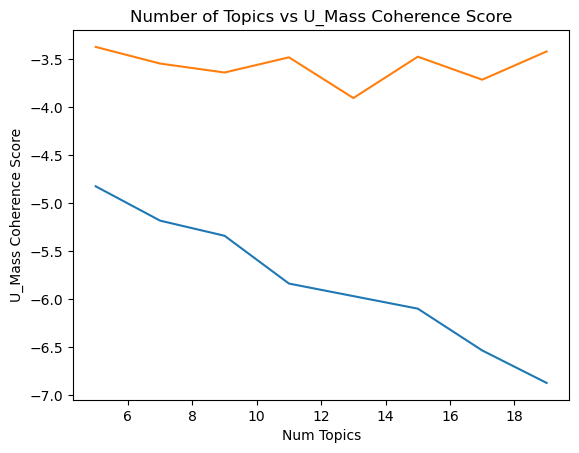

In [71]:
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.title("Number of Topics vs U_Mass Coherence Score")
plt.plot(x, u_mass_b)
plt.plot(x, mean_umass)
plt.xlabel("Num Topics")
plt.ylabel("U_Mass Coherence Score")
plt.savefig("u_mass_number_of_topic.png")
plt.show()

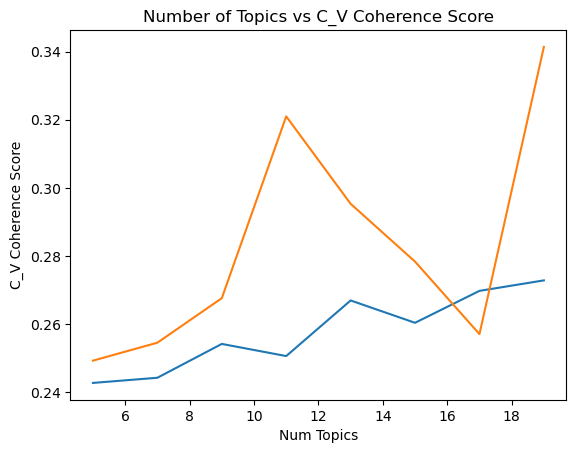

In [72]:
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.title("Number of Topics vs C_V Coherence Score")
plt.plot(x, c_v_b)
plt.plot(x, mean_cv)
plt.xlabel("Num Topics")
plt.ylabel("C_V Coherence Score")
plt.savefig("c_v_number_of_topic.png")
plt.show()

NameError: name 'perp_b' is not defined

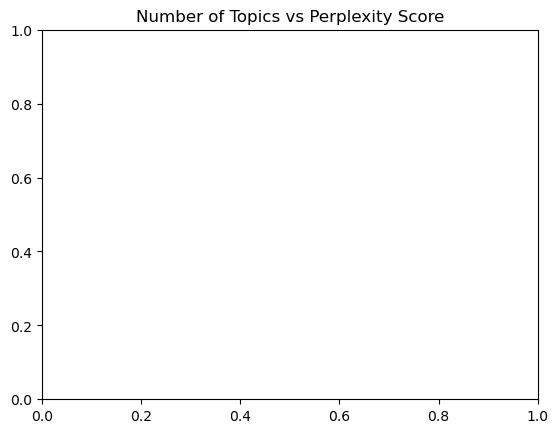

In [38]:
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.title("Number of Topics vs Perplexity Score")
plt.plot(x, perp_b)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity Score")
plt.savefig("perp_number_of_topic.png")
plt.show()

perplexity not very much affected

### Actual RUN- LDA

In [ ]:
# dictionary = corpora.Dictionary(B_clean["gram_model_tweets"])
# corpus = [dictionary.doc2bow(text) for text in B_clean["gram_model_tweets"].values]

In [ ]:
lt = B_clean["gram_model_tweets"][:1000]
dictionary = corpora.Dictionary(lt)
corpus = [dictionary.doc2bow(text) for text in lt.values]

In [ ]:
#chunk size- number of elements of corpus to include in each training
#random state- random seed

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=11, 
                                           random_state=2134,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=10,
                                           iterations=10,
                                           alpha='auto',
                                           eval_every=None,
                                           per_word_topics=True)

In [ ]:
#https://www.projectpro.io/recipes/save-and-load-lda-model-gensim
# saving model to disk.

from gensim.test.utils import datapath
temp_file = datapath("/kaggle/working/lda_model_biden")
lda_model.save(temp_file)

#loading model from disk

# from gensim import models
# lda = models.ldamodel.LdaModel.load(temp_file)

In [ ]:
lda_model.print_topics()
#0- Hunter Biden scandals involving Ukraine and China
#1- Tweets voicing "Vote for Democrats" (Joe Biden)
#2- CNN, FoxNews, and other media outlet used as a medium for Fake News 
#3- BLM campaign and fraud voters in regards to the Sunday Results day
#4- Against Trump with regards to Racial Issues
#5- Against Biden in general
#6- Congratulating Kamala and Joe for winning the presidential election
#7- Election Day Voting and Results Day
#8- Policies and Issues pertaining to 2020
#9- Presidential Debate
#10- General Public Discourse
#11- Candidate Tax Policies and statements
#12- States that Joe Biden took lead in before results day
#13- Biden winning by a landslide- telling Trump to go away
#14- Calls for vote in person in PA, WI, MI over mail ballots (tag)


#0- Presidential Candiadate's Presidential Debates
#1- Hunter Biden's scandals involving Ukraine and China
#2- Biden vs Trump Comparison Tweets (Pro Biden)
#3- Issues Debated during the Presidential Debate- COVID, RACE, CLIMATE CHANGE, etc 
#4- Biden Harris winning the election
#5- Black Lives Matter and Catholic Church
#6- Biden's Win over Trump
#7- Media Outlets' news on 2020 election
#8- Voting for Biden/Democrats
#9- Lincoln Project and Climate Change
#10- 2020 Election Results 

LDA is a great tool for topic modeling however it falls short for text with smaller than 50 words. Therefore our attempt at using lda for topic modeling led to a failure- therefore not using that

In [ ]:
from gensim.models import CoherenceModel
umass_coherence_b = CoherenceModel(model=lda_model,texts=B_clean["gram_model_tweets"],dictionary=dictionary,
                                    coherence='u_mass')

coherence_umass_b = umass_coherence_b.get_coherence()

print('\nCoherence Score- UMass:',coherence_umass_b)


In [ ]:
cv_coherence_b = CoherenceModel(model=lda_model,texts=B_clean["gram_model_tweets"],dictionary=dictionary,
                                    coherence='c_v')

In [ ]:
coherence_cv_b = cv_coherence_b.get_coherence()
print('Coherence Score- C_V: ', coherence_cv_b)

In [ ]:
# cv_coherence_b = CoherenceModel(model=lda_model, texts=B_clean["gram_model_tweets"], dictionary=dictionary, coherence='c_v')
# coherence_cv_b = cv_coherence_b.get_coherence()
# print('Coherence Score: ', coherence_cv_b)

In [ ]:
perplexity_b = lda_model.log_perplexity(corpus)
print(np.exp2(-perplexity_b))

In [ ]:
vis_b = pyLDAvis.gensim.prepare(topic_model=lda_model, 
                              corpus=corpus, 
                              dictionary=dictionary)
pyLDAvis.save_html(vis_b, 'lda_biden.html')
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_b)

In [ ]:
topic_weights_b = []
for i in range(len(corpus)):
#     if len(lda_model[corpus[i]][0]) != 10:
    r = 0
    new_l = list()
    #lda_model[corpus[i]][0].copy()
    for (x,y) in lda_model[corpus[i]][0]:
        if x != r:
            for m in range(x - r):
#               new_l.insert(r + m, (r + m, 0))
                new_l.append(0)
                r+=1
        new_l.append(y)
        r+=1
    topic_weights_b.append(new_l)
# topic_weights_b[:10]

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [ ]:
matrix_b = pd.DataFrame(topic_weights_b).fillna(0).values
topic_num = np.argmax(matrix_b, axis=1)

In [ ]:
np.savetxt('lda_comboresults_biden.csv', matrix_b, delimiter=',')

In [ ]:
top_topics = matrix_b.argmax(axis=1).tolist()

In [ ]:
for i in set(top_topics):
    print(i, top_topics.count(i))

In [ ]:
#B_clean["state_code"]

In [ ]:
#output_notebook()
n_topics = 11
mycolors = plt.get_cmap('hsv')(np.linspace(0, 1, n_topics))

In [ ]:
# tSNE Dimension Reduction
#https://www.kaggle.com/code/ykhorramz/lda-and-t-sne-interactive-visualization/notebook
tsne_lda_model_3 = TSNE(n_components=3, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=13240, angle=0.75)
tsne_lda_vectors_3 = tsne_lda_model_3.fit_transform(matrix_b)

In [ ]:
matrix_c = []
for i in range(len(top_topics)):
    if top_topics[i] != 2:
       matrix_c.append(tsne_lda_vectors_3[i])

In [ ]:
fig1 = px.scatter_3d(
    tsne_lda_vectors_3, x=0, y=1, z=2,
    color=top_topics, opacity=0.2,
    title="TSNE Clustering for Public Tweets towards Joe Biden during 2020 Election (1)"
)
fig1.update_traces(marker_size=2)
fig1.write_html("tsne_biden_all.html")
fig1.show()

In [ ]:
fig = px.scatter_3d(
    matrix_c, x=0, y=1, z=2,
    color=[i for i in top_topics if i!= 2], opacity=0.2,
    title="TSNE Clustering for Public Tweets towards Joe Biden during 2020 Election (2)"
)
#, labels={'color': list(range(15))}
fig.update_traces(marker_size=2)
fig1.write_html("tsne_biden_omit.html")
fig.show()

##### TRUMP Dataset


In [ ]:
T_clean = T_US_english[(T_US_english['state_code'] != "GU") & (T_US_english['state_code'] != "PR") & (T_US_english['state_code'] != "MP")]

In [ ]:
#removes emojis- as they have no relevance to topics
T_clean['clean_tweet'] = T_clean['tweet'].apply(lambda x: demoji.replace(x, ""))
#removes &amp;
T_clean['clean_tweet'] = T_clean['clean_tweet'].apply(lambda x: re.sub("&amp;","", x))
#removes @
T_clean['clean_tweet'] = T_clean['clean_tweet'].apply(lambda x: re.sub(at_symbol,"", x))
#removes http
T_clean['clean_tweet'] = T_clean['clean_tweet'].apply(lambda x: re.sub(hyper_link,"", x))
T_clean['clean_tweet'] = T_clean['clean_tweet'].apply(lambda x: re.sub(hyper_link2,"", x))
#remove new line symbol
T_clean['clean_tweet'] = T_clean['clean_tweet'].apply(lambda x: re.sub("\n","", x))
#remove 's
T_clean['clean_tweet'] = T_clean['clean_tweet'].apply(lambda x: re.sub("'s","", x))
# https://stackoverflow.com/questions/68448243/efficient-way-to-split-multi-word-hashtag-in-python
T_clean['clean_tweet'] = T_clean['clean_tweet'].apply(lambda x: re.sub(r'#[a-zA-Z]+', lambda m: ' '.join(re.findall('[A-Z][^A-Z]*|[a-z][^A-Z]*', m.group().lstrip('#'))), x))
# Remove punctuation
T_clean['clean_tweet'] = T_clean['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
#remove camel case
T_clean['clean_tweet'] = T_clean['clean_tweet'].apply(lambda x: re.sub(r'(?<=[a-z])(?=[A-Z])|(?<=[A-Za-z])(?=[0-9])', ' ', x))

In [ ]:
T_clean['clean_tweet'] = clean_tweets(list(T_clean['clean_tweet']))

In [ ]:
lemmatized_tweets_t = list()
for t in T_clean['clean_tweet']:
    word_list = nltk.word_tokenize(t)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w).upper() for w in word_list if len(str(w)) != 1 and re.search('[a-zA-Z]', str(w)) != None])
    lemmatized_tweets_t.append(lemmatized_output)
T_clean['lemmatized_tweets'] = lemmatized_tweets_t

In [ ]:
tokenized_lemmatised_t = list()
for i in T_clean["lemmatized_tweets"]:
    tokenized_lemmatised_t.append(i.split())

In [ ]:
bigram_t = gensim.models.Phrases(tokenized_lemmatised_t, min_count=1500, threshold=1) # higher threshold fewer phrases.
trigram_t = gensim.models.Phrases(bigram_t[tokenized_lemmatised_t], min_count=2000, threshold=1)  
# bigram_t = gensim.models.Phrases(tokenized_lemmatised_b, min_count=15, threshold=1) # higher threshold fewer phrases.
# trigram_t = gensim.models.Phrases(bigram_b[tokenized_lemmatised_b], min_count=20, threshold=1)  
bigram_mod_t = gensim.models.phrases.Phraser(bigram_t)
trigram_mod_t = gensim.models.phrases.Phraser(trigram_t)

In [ ]:
gram_model_t = list()
gram_model_joined_t = list()
for i in tokenized_lemmatised_t:
    gram_model_t.append(trigram_mod_t[bigram_mod_t[i]])
    gram_model_joined_t.append(" ".join(trigram_mod_t[bigram_mod_t[i]]))
T_clean["gram_model_tweets"] = gram_model_t
T_clean["gram_model_joined_tweets"] = gram_model_joined_t

In [ ]:
# for i in T_clean["gram_model_joined_tweets"]:
#     print(i)

In [ ]:
results_topics_trump = subset_runs(T_clean, 5, 30000)

In [ ]:
results_topics_t = results_topics_trump

In [ ]:
u_mass_t = pd.DataFrame(results_topics_t[0][1]).T
c_v_t = pd.DataFrame(results_topics_t[0][2]).T
perp_t = pd.DataFrame(results_topics_t[0][3]).T
for i in range(1, 5, 1):
    u_mass_t = u_mass_t.append(pd.Series(results_topics_t[i][1], index=u_mass_.columns[:len(results_topics_t[i][1])]), ignore_index=True)
    c_v_t = c_v_t.append(pd.Series(results_topics_t[i][2], index=c_v_t.columns[:len(results_topics_t[i][2])]), ignore_index=True)
    perp_t = perp_t.append(pd.Series(results_topics_t[i][3], index=perp_t.columns[:len(results_topics_t[i][3])]), ignore_index=True)

In [ ]:
umass_trump = pd.DataFrame(u_mass_t)
cv_trump = pd.DataFrame(c_v_t)
perp_trump = pd.DataFrame(perp_t)
umass_trump.to_csv(r'/kaggle/working/umass_trump.csv', index=False)
cv_trump.to_csv(r'/kaggle/working/cv_trump.csv', index=False)
perp_trump.to_csv(r'/kaggle/working/perp_trump.csv', index=False)

In [ ]:
u_mass_tt = list(u_mass_trump.mean())
c_v_tt = list(c_v_trump.mean())
perp_tt = list(perp_trump.mean())

In [ ]:
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.title("Number of Topics vs U_Mass Coherence Score (Trump Dataset)")
plt.plot(x, u_mass_tt)
plt.xlabel("Num Topics")
plt.ylabel("U_Mass Coherence Score")
plt.savefig("u_mass_number_of_topic_trump.png")
plt.show()

In [ ]:
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.title("Number of Topics vs C_V Coherence Score (Trump Dataset)")
plt.plot(x, c_v_tt)
plt.xlabel("Num Topics")
plt.ylabel("C_V Coherence Score")
plt.savefig("c_v_number_of_topic_trump.png")
plt.show()

In [ ]:
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.title("Number of Topics vs Perplexity Score (Trump Dataset)")
plt.plot(x, perp_tt)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity Score")
plt.savefig("perp_number_of_topic_trump.png")
plt.show()

In [ ]:
dictionary_t = corpora.Dictionary(T_clean["gram_model_tweets"])
corpus_t = [dictionary_t.doc2bow(text) for text in T_clean["gram_model_tweets"].values]

In [ ]:
lda_model_t = gensim.models.ldamodel.LdaModel(corpus=corpus_t,
                                           id2word=dictionary_t,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=10,
                                           iterations=10,
                                           alpha='auto',
                                           eval_every=None,
                                           per_word_topics=True)

In [ ]:
lda_model_t.print_topics()